## SR


In [1]:
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:

def sr_to_pil(sr_tensor):
    """sr_tensor: [3,H,W] or [B,3,H,W] float in [-1,1] returns: PIL Image (RGB)"""
    if sr_tensor.dim() == 4:
        sr_tensor = sr_tensor[0] # first in batch
    sr_tensor = ((sr_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8)
    sr_np = sr_tensor.permute(1,2,0).cpu().numpy()
    return Image.fromarray(sr_np)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
A compact super-resolution EDM UNet with:
* Low-res encoder tower (16×16 features)
* Cross-attention block
* UNet with skip connections (small, memory-friendly)
* Sigma embedding channel
* Plus a sanity-check at the end that passes dummy data through it to verify shapes.
"""

# -------------------------------
# 1) Low-res encoder tower
# -------------------------------
class LowResEncoder(nn.Module):
    def __init__(self, in_ch=3, base_ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((16,16))  # shrink to small feature map
        )
    def forward(self, x):
        return self.net(x)  # [B, base_ch, 16,16]

# -------------------------------
# 2) Cross-attention block
# -------------------------------
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q, dim_kv, dim_out):
        super().__init__()
        self.q_proj = nn.Conv2d(dim_q, dim_out, 1)
        self.k_proj = nn.Conv2d(dim_kv, dim_out, 1)
        self.v_proj = nn.Conv2d(dim_kv, dim_out, 1)
        self.out_proj = nn.Conv2d(dim_out, dim_out, 1)

    def forward(self, x, cond):
        # flatten spatial dims
        B,C,H,W = x.shape
        _,D,h,w = cond.shape
        q = self.q_proj(x).flatten(2).transpose(1,2)      # [B, HW, C]
        k = self.k_proj(cond).flatten(2).transpose(1,2)   # [B, h*w, C]
        v = self.v_proj(cond).flatten(2).transpose(1,2)   # [B, h*w, C]

        attn = torch.softmax(q @ k.transpose(-2,-1) / (C**0.5), dim=-1)
        out = attn @ v  # [B, HW, C]
        out = out.transpose(1,2).reshape(B,C,H,W)
        return self.out_proj(out) + x

# -------------------------------
# 3) Small UNet block with skip connections
# -------------------------------
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU()
    def forward(self, x):
        x1 = self.act(self.conv1(x))
        x2 = self.act(self.conv2(x1))
        return x2, x1  # output + skip

class UNetUpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch+skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU()
    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

# -------------------------------
# 4) Full SR-UNet w/ conditioning
# -------------------------------
class SRUNet(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()
        self.cond_enc = LowResEncoder()
        self.down1 = UNetBlock(3+1, base_ch)         # +1 for sigma embed
        self.down2 = UNetBlock(base_ch, base_ch*2)
        self.mid = nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1)
        self.cross = CrossAttentionBlock(base_ch*2, base_ch, base_ch*2)
        self.up2 = UNetUpBlock(base_ch*2, base_ch*2, base_ch)
        self.up1 = UNetUpBlock(base_ch, base_ch, 3) # output RGB

    def forward(self, x_noisy, lowres, sigma_embed):
        # x_noisy: [B,3,H,W], sigma_embed: [B,1,H,W]
        cond_feat = self.cond_enc(lowres)  # [B,C,16,16]

        # down path
        x = torch.cat([x_noisy, sigma_embed], dim=1)
        d1, skip1 = self.down1(x)
        d2, skip2 = self.down2(d1)

        # mid + cross attention
        mid = self.mid(d2)
        mid = self.cross(mid, cond_feat)

        # up path
        u2 = self.up2(mid, skip2)
        out = self.up1(u2, skip1)
        return out

# -------------------------------
# 5) Sanity check
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRUNet().to(device)
B,H,W = 2,256,256
lr = torch.randn(B,3,H//4,W//4).to(device)       # low-res input
hr_noisy = torch.randn(B,3,H,W).to(device)
sigma_embed = torch.randn(B,1,H,W).to(device)

with torch.no_grad():
    out = model(hr_noisy, lr, sigma_embed)
print("Input noisy HR shape:", hr_noisy.shape)
print("Low-res shape:", lr.shape)
print("Sigma embed shape:", sigma_embed.shape)
print("Output shape:", out.shape)  # should be [B,3,H,W]


Input noisy HR shape: torch.Size([2, 3, 256, 256])
Low-res shape: torch.Size([2, 3, 64, 64])
Sigma embed shape: torch.Size([2, 1, 256, 256])
Output shape: torch.Size([2, 3, 256, 256])


In [8]:
num_params = sum(p.numel() for p in model.parameters())
print(f"SRUNet number of parameters: {num_params:,}")

SRUNet number of parameters: 684,695


In [4]:
import torch
import torch.nn.functional as F

# -------------------------------
# EDM constants
# -------------------------------
SIGMA_DATA = 0.5       # data std for [-1,1] images
P_MEAN = -1.2
P_STD  = 1.2
SIGMA_MIN = 0.002
SIGMA_MAX = 0.5        # smaller max sigma for 6GB GPU
RHO = 7.0

# EDM loss weighting
def edm_loss_weight(sigma, sigma_data=SIGMA_DATA):
    return (sigma**2 + sigma_data**2) / (sigma * sigma_data)**2

# -------------------------------
# 1) EDM preconditioned training step
# -------------------------------
def edm_train_step(model, hr, lr, optimizer):
    """
    hr: [B,3,H,W] in [-1,1]
    lr: [B,3,H//4,W//4] in [-1,1]
    """
    B,H,W = hr.shape[0], hr.shape[2], hr.shape[3]

    # 1) Sample log-normal σ per batch
    rnd = torch.randn(B, device=hr.device)
    sigma = (rnd * P_STD + P_MEAN).exp()   # [B]

    # 2) Preconditioning coefficients (per batch)
    c_skip = (SIGMA_DATA**2) / (sigma**2 + SIGMA_DATA**2)    # [B]
    c_out  = (sigma * SIGMA_DATA) / torch.sqrt(sigma**2 + SIGMA_DATA**2)  # [B]
    c_in   = 1 / torch.sqrt(sigma**2 + SIGMA_DATA**2)        # [B]
    c_noise = torch.log(sigma)/4                              # [B]

    # 3) Add noise to HR
    noise = torch.randn_like(hr)                              # [B,3,H,W]
    x_noisy = hr + sigma.view(B,1,1,1) * noise               # [B,3,H,W]

    # 4) Upsample LR to HR resolution
    lr_up = F.interpolate(lr, size=(H,W), mode='bilinear', align_corners=False)  # [B,3,H,W]

    # 5) Broadcast σ embedding to match spatial size
    sigma_map = c_noise.view(B,1,1,1).expand(-1,1,H,W)       # [B,1,H,W]

    # 6) Forward pass through model
    # Concatenate channels: x_noisy [B,3,H,W], sigma_map [B,1,H,W] -> input [B,4,H,W]
    F_x = model(c_in.view(B,1,1,1)*x_noisy, lr_up, sigma_map)  # [B,3,H,W]

    # 7) Preconditioned prediction
    D_x = c_skip.view(B,1,1,1) * x_noisy + c_out.view(B,1,1,1) * F_x  # [B,3,H,W]

    # 8) Weighted EDM loss
    weight = edm_loss_weight(sigma).view(B,1,1,1)            # [B,1,1,1]
    loss = (weight * (D_x - hr)**2).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    return loss.item()

# -------------------------------
# 2) EDM ancestral sampling
# -------------------------------
@torch.no_grad()
def edm_sample(model, lr, num_steps=18):
    """
    Generate SR conditioned on LR input.
    lr: [B,3,H//4,W//4]
    returns: [B,3,H,W]
    """
    device = lr.device
    B,H_lr,W_lr = lr.shape[0], lr.shape[2], lr.shape[3]
    H, W = H_lr*4, W_lr*4   # HR size

    # 1) EDM sigma schedule
    step_idx = torch.arange(num_steps, device=device)
    sigmas = (SIGMA_MAX**(1/RHO) + step_idx/(num_steps-1)*(SIGMA_MIN**(1/RHO)-SIGMA_MAX**(1/RHO)))**RHO
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # t_N = 0

    # 2) Start from Gaussian noise
    x = torch.randn(B,3,H,W, device=device) * SIGMA_MAX           # [B,3,H,W]

    # 3) Upsample LR to HR
    lr_up = F.interpolate(lr, size=(H,W), mode='bilinear', align_corners=False)  # [B,3,H,W]

    # 4) Sampling loop
    for i in range(num_steps):
        sigma_i, sigma_next = sigmas[i], sigmas[i+1]

        # Preconditioning
        c_skip = SIGMA_DATA**2 / (sigma_i**2 + SIGMA_DATA**2)
        c_out  = sigma_i * SIGMA_DATA / torch.sqrt(sigma_i**2 + SIGMA_DATA**2)
        c_in   = 1 / torch.sqrt(sigma_i**2 + SIGMA_DATA**2)
        c_noise = torch.log(sigma_i)/4

        # Broadcast σ embedding to match spatial dimensions
        sigma_map = c_noise.view(1,1,1,1).expand(B,1,H,W)       # [B,1,H,W]

        # Model prediction: concatenate x [B,3,H,W] + sigma_map [B,1,H,W] -> [B,4,H,W]
        F_x = model(c_in*x, lr_up, sigma_map)                    # [B,3,H,W]

        # Preconditioned denoised output
        denoised = c_skip * x + c_out * F_x                     # [B,3,H,W]

        # Compute Euler step
        d_cur = (x - denoised) / sigma_i
        dt = sigma_next - sigma_i
        x = x + d_cur * dt

        # Optional ancestral noise
        if sigma_next > 0:
            noise = torch.randn_like(x) * max(sigma_next**2 - sigma_i**2, 0)**0.5
            x = x + noise

    return x.clamp(-1,1)


In [5]:

# -------------------------------
# 4) Sanity check
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

B,H,W = 2,256,256
hr = torch.randn(B,3,H,W).to(device)
lr = torch.randn(B,3,H//4,W//4).to(device)

loss = edm_train_step(model, hr, lr, optimizer)
print("Train step loss:", loss)

sampled = edm_sample(model, lr, num_steps=6)
print("Sampled output shape:", sampled.shape)


Train step loss: 2.3996293544769287
Sampled output shape: torch.Size([2, 3, 256, 256])


Step 1/3, loss: 1.09
Step 2/3, loss: 1.19
Step 3/3, loss: 1.17


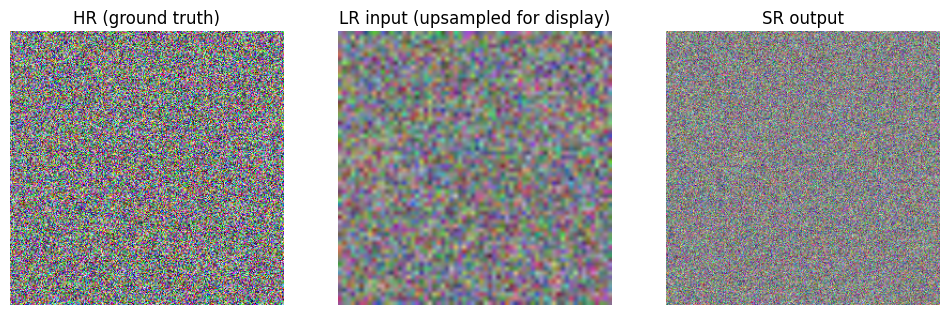

In [6]:
import matplotlib.pyplot as plt

# -------------------------------
# 1) Tiny synthetic dataset
# -------------------------------
BATCH_SIZE = 2
H, W = 256, 256
LR_SCALE = 4

def get_synthetic_batch(batch_size=BATCH_SIZE):
    """
    Returns:
        hr: [B,3,H,W] in [-1,1]
        lr: [B,3,H//4,W//4] in [-1,1]
    """
    hr = torch.rand(batch_size, 3, H, W) * 2 - 1       # [-1,1]
    lr = F.interpolate(hr, size=(H//LR_SCALE, W//LR_SCALE), mode='bilinear', align_corners=False)
    return hr, lr

# -------------------------------
# 2) Training / sampling loop
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRUNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_steps = 3   # small number just for testing
for step in range(num_steps):
    hr, lr = get_synthetic_batch()
    hr, lr = hr.to(device), lr.to(device)

    loss = edm_train_step(model, hr, lr, optimizer)
    print(f"Step {step+1}/{num_steps}, loss: {loss:.2f}")

# -------------------------------
# 3) Sampling from the model
# -------------------------------
hr, lr = get_synthetic_batch()
lr = lr.to(device)
with torch.no_grad():
    sr_out = edm_sample(model, lr, num_steps=6)  # small steps for sanity

# -------------------------------
# 4) Visualization
# -------------------------------
hr_np = hr[0].permute(1,2,0).cpu().numpy()
lr_np = F.interpolate(lr[0:1], size=(H,W), mode='bilinear')[0].permute(1,2,0).cpu().numpy()
sr_np = sr_out[0].permute(1,2,0).cpu().numpy()

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow((hr_np+1)/2)
axes[0].set_title("HR (ground truth)")
axes[1].imshow((lr_np+1)/2)
axes[1].set_title("LR input (upsampled for display)")
axes[2].imshow((sr_np+1)/2)
axes[2].set_title("SR output")
for ax in axes:
    ax.axis('off')
plt.show()


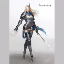

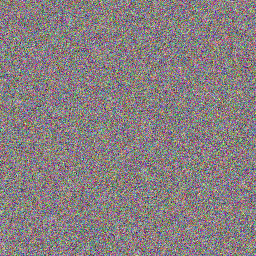

[Epoch 14 Step 350] Loss 0.83, saved SR sample.
Epoch 14 complete. Last batch loss: 0.83


KeyboardInterrupt: 

In [7]:
import os, time
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# -------------------------------
# 1) Dataset wrapper
# -------------------------------
class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, hr_paths, lr_size=64):
        self.hr_paths = hr_paths
        self.lr_size = lr_size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.5]*3, [0.5]*3)  # scale [-1,1]

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_paths[idx]).convert("RGB")
        hr = self.to_tensor(hr)
        hr = self.normalize(hr)
        lr = F.interpolate(hr.unsqueeze(0), size=(self.lr_size,self.lr_size), mode='bilinear', align_corners=False)[0]
        return hr, lr

# -------------------------------
# 2) Training + sampling loop
# -------------------------------
def train_sr(model, hr_paths, batch_size=2, num_epochs=1, steps_per_sample=5, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    dataset = PairedDataset(hr_paths)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    step = 0
    os.makedirs("sr_samples", exist_ok=True)
    for epoch in range(num_epochs):
        for hr, lr in loader:
            hr, lr = hr.to(device), lr.to(device)

            loss = edm_train_step(model, hr, lr, optimizer)
            step += 1

            if step % steps_per_sample == 0:
                # sample
                with torch.no_grad():
                    sr = edm_sample(model, lr, num_steps=6)

                # save first image in batch
                hr_img = sr_to_pil(lr)
                sr_img = ((sr[0].cpu()+1)/2*255).clamp(0,255).byte().permute(1,2,0).numpy()
                ipd.clear_output(wait=True)
                ipd.display(hr_img)
                ipd.display(Image.fromarray(sr_img))
                print(f"[Epoch {epoch+1} Step {step}] Loss {loss:.2f}, saved SR sample.")

        print(f"Epoch {epoch+1} complete. Last batch loss: {loss:.2f}")

    # final checkpoint
    torch.save(model.state_dict(), "sr_unet_final.pt")
    print("Training complete. Model checkpoint saved.")

# -------------------------------
# 3) Usage example
# -------------------------------
# Replace this with paths to a few HR images for testing
import glob
example_hr_paths = ["data/256x256/mnist/img/000000.webp","data/256x256/mnist/img/000001.webp"]
example_hr_paths = glob.glob("data/256x256/fantasy/img/0000*.webp")[0:100]
model = SRUNet()
train_sr(model, example_hr_paths, batch_size=4, num_epochs=100, steps_per_sample=10)


# Mine

In [ ]:
# TODO - re-merge with the one above
def edm_ancestral_sampling(model, lr_up, num_steps=18, batch_size=8, img_shape=(1, 28, 28),
                           headstart_sigma:float|None=None):
    """
        EDM ancestral sampling with optional noisy-LR head-start.
        
        Args:
            model: UNet denoiser
            lr_up: upscaled LR image [B, 3, H, W]
            num_steps: number of sampling steps
            batch_size: batch size
            img_shape: shape of output images
            headstart_sigma: float or None
                If None, start from pure noise.
                If float, adds Gaussian noise with this std to lr_up for head-start.
    """
    device = next(model.parameters()).device
    
    # Initialize noise
    # ------------------- Head-start initialization -------------------
    if headstart_sigma is None:
        # Original behavior: pure Gaussian noise
        x_next = torch.randn((batch_size,) + img_shape, device=device)
    else:
        # Start from LR upsample + moderate noise
        lr_up_resized = F.interpolate(lr_up, size=img_shape[-2:], mode='bilinear', align_corners=False)
        x_next = lr_up_resized.to(device) + headstart_sigma * torch.randn((batch_size,) + img_shape, device=device)
    # ------------------------------------------------------------------

    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    #-----------------------------------------------------
    # after head-start initialization
    if headstart_sigma is not None:
        """
        https://chatgpt.com/share/68c6111a-55d0-800b-b1b3-14e3cf3ff731
        Some papers also rescale the remaining t_steps proportionally to account for the lower starting noise, so the schedule adapts dynamically. But the simplest correct approach is just to replace the first t_steps[0] with the actual headstart_sigma.
        """
        t_steps[0] = headstart_sigma
    #-----------------------------------------------------
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        this_models_input = torch.cat([c_in*x_cur, lr_up], dim=1).cuda()
        #F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        F_x = model(this_models_input, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            #F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            this_models_input = torch.cat([c_in_next * x_next, lr_up], dim=1).cuda()
            F_x_next = model(this_models_input, c_noise_next.expand(batch_size))


            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")